# Model creation. CNN for environmental sound classification
-  In this notebook a CNN for Environmental Sound Classification is programmed. It was then trained on the public dataset UrbanSound8K, which consists of sounds corresponding to ten different classes.




## Dependencies

-  Tensorflow (version 1.1.0, when programmed)
-  A package (imported below) that I created for a cleaner programming of the model. It is available on the repository. 
-  The dataset to train the model

### Sketch of the network arquitecture

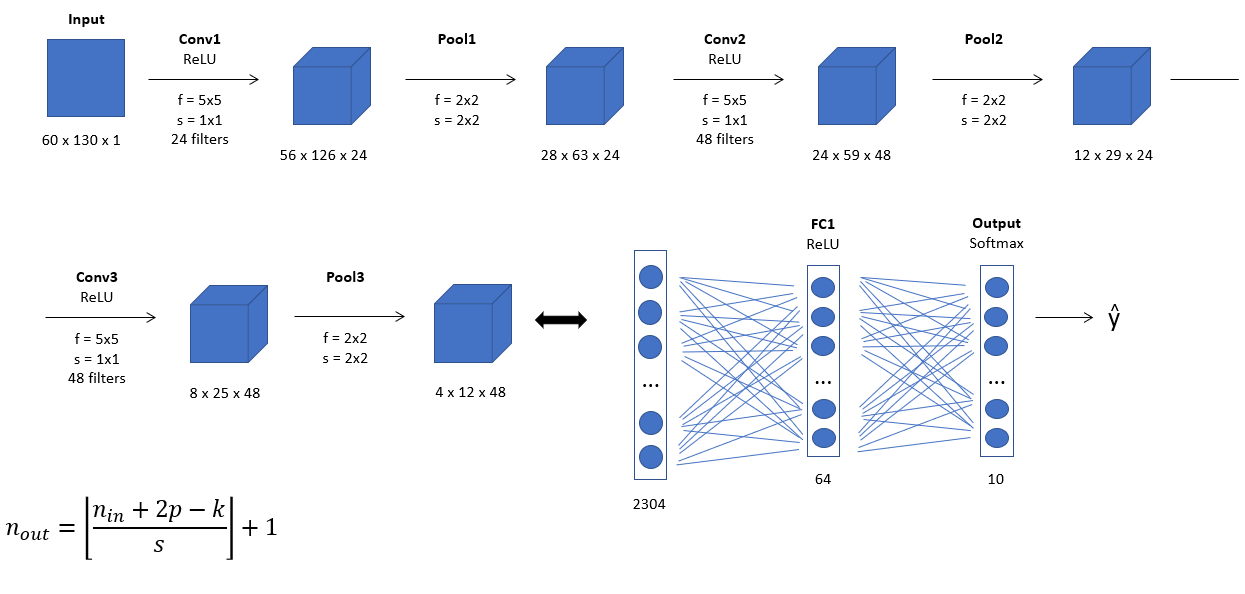

In [16]:
from IPython.display import Image
Image(filename = r"C:\Users\Santiago\Desktop\Application Noise Map\Master Thesis\Pictures for Latex document\Arquitecture_BuyllaNET.png")


In [1]:
# Let's import some packages
import santiago_my_modules_v3_16_04_18 as my
import imp 
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.python.framework import ops
from cnn_utils import * # random mini batches
from datetime import datetime


## Let's start with our Neural Network
Here are some of the parameters of the model:
> __Layers__ <br> 3 Conv layers + 3 Max-Pooling layers + 2 FC layers <br> layer1.shape = (5,5,1,24), that is f=5, n_C=1, #filters = 24; followed by __max-pooling__ (2x2,2x2) where (f,s), and ReLU activation <br> layer2.shape = (5,5,24,48), __max-pooling__ (2x2,2x2), ReLU activation function <br> layer3.shape = (5,5,48,48) ,__max-pooling__ (2x2,2x2), ReLU activation <br> layer4.shape = (64,2304), FC layer with 64 hidden units followed by ReLU activation function <br> layer5.shape = (10,64), 10 hidden units, Softmax activation function. <br> 'VALID' padding is used throughout the whole network 
<br><br> __Hyperparameters__ <br> Loss function: cross-entropy loss via mini-batch stochastic GD <br> Batch size: 50 TF patches, 3 s duration (randomly selected from the 4s of each audio clip) <br> Learning rate: 0.001 <br> Dropout: applied to the input of layers 4&5, with p = 0.5 <br> L2 regularization is applied to the weights of the last 2 layers, penalty factor = 0.0025<br>  Number of epochs: 50<br>Optimizer: Adam <br> <br>
__Input to the network__ <br> TF patches from the log-scaled mel-spectogram representation of the audio signal. Duration = 3 seconds. <br> 



    

## Load dataset and normalize inputs

In [10]:
# LOAD DATASET
X = np.load(r'C:\Users\Santiago\deep-machine-learning\UrbanSound8K_Treated\deprueba\features_mel.npy')
Y = np.load(r'C:\Users\Santiago\deep-machine-learning\UrbanSound8K_Treated\deprueba\labels.npy')

X = np.transpose(X, axes =(2,0,1))  # after this line: Shape [examples,60,130]
print("Shape of X = " +str(X.shape))
print("Shape of Y = " +str(Y.shape))

# SPLIT DATASET INTO TRAINING/TEST SETS - I will train on 8 folders and use 1 for testing. 
files_per_folder = [22, 888, 925, 990, 936, 823, 838, 806, 816, 837] 

validation_folder = 0 #I won't use one of the folders since that is the one Bello&Piczak used for validation
test_folder = 0
X_train, Y_train, X_val, Y_val, X_test, Y_test  = my.split_dataset(X, Y, validation_folder, test_folder, files_per_folder)

# GET RIGHT DIMENSIONS
X_train = np.transpose(np.array(X_train, ndmin = 4), axes = (1,2,3,0))
X_val = np.transpose(np.array(X_val, ndmin = 4), axes = (1,2,3,0))
X_test = np.transpose(np.array(X_test, ndmin = 4), axes = (1,2,3,0))

# NORMALIZE INPUTS TO HAVE MEAN = 0 AND VARIANCE = 1
mean = np.mean(X_train, axis = 0)
std = np.std(X_train, axis = 0)

X_train = (X_train-mean)/std
X_test = (X_test-mean)/std
X_val = (X_val-mean)/std       # apply the same transformation to the validation and test data


# ONE HOT ENCODING OF THE LABELS
Y_train = np.transpose(convert_to_one_hot(Y_train, 10))
Y_val = np.transpose(convert_to_one_hot(Y_val, 10))
Y_test = np.transpose(convert_to_one_hot(Y_test, 10))


# PRINT SOME INFORMATION ABOUT THE TRAIN/TEST SETS
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

print(X_train.shape[0]+X_test.shape[0]+X_val.shape[0])




Shape of X = (60, 60, 130)
Shape of Y = (60,)
number of training examples = 16
number of test examples = 22
number of validation examples = 22
X_train shape: (16, 60, 130, 1)
Y_train shape: (16, 10)
X_val shape: (22, 60, 130, 1)
Y_val shape: (22, 10)
X_test shape: (22, 60, 130, 1)
Y_test shape: (22, 10)
60


# Create the model

In [5]:
def model(X_train, Y_train, X_val, Y_val, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True, dropout = 1,
          dropout_conv = 1, lambd = 0, index = 0, n_hidden_fc1 = 64, BN = False):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> FLATTEN -> FULLYCONNECTED -> RELU -> SOFTMAX
    
    Arguments:
    X_train -- training set, of shape (None, 60, 130, 1)
    Y_train -- test set, of shape (None, n_y = 10)
    X_val ---- validation set, of shape (None, 60, 130, 1)
    Y_val ---- validation set, of shape (None, n_y = 10)
    X_test --- test set, of shape (None, 60, 130, 1)
    Y_test --- test set, of shape (None, n_y = 10)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 5 epochs
    dropout -- probability of dropout regularization in the FC layers
    dropout_conv -- probability of dropout in the conv layers
    lambd -- L2 regularization term
    index --- to keep track for debugging
    n_hidden_fc1 -- number of hidden units of the first FC layer
    BN -- Boolean. Whether to apply batch normalization or not
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy --- real number, accuracy on the test set (X_test)
    dev accuracy ---- real number, accuracy on the validation set (X_val)
    parameters ------ parameters learnt by the model. They can then be used to predict.
    
    """
    
    tf.reset_default_graph()                          # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    
    # Obtaining shapes from data
    m, n_H0, n_W0, n_C0 = X_train.shape
    n_y = Y_train.shape[1]             
    
    # Empty list to keep track of the cost per epoch
    costs = []                                       
    
    # Create Placeholders 
    X, Y, keep_prob, keep_prob_conv, BN_istrain = my.create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z5, parameters = my.forward_propagation_with_dropout(X, keep_prob, keep_prob_conv, n_hidden_fc1,
                                                         BN_istrain = BN_istrain, BN = BN)
        
    # Cost function: Add cost function to tensorflow graph
    if lambd == 0:
        cost = my.compute_cost(Z5, Y)
    else:
        cost = my.compute_cost_with_regularization(Z5, Y, parameters, lambd)

    # Adam optimizer
    with tf.name_scope('train'):
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    # Create a save instance in order to save the trained variables and the graph definition
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = r'C:\Users\Santiago\deep-machine-learning\UrbanSound8K_Treated\Deprueba\Saved_Model' + str(index)
    logdir0 = "{}/saved_model_run-{}/".format(root_logdir, now)
    builder = tf.saved_model.builder.SavedModelBuilder(logdir0)
    
    # Creates a summary file writer
    logdir = "{}/event_run-{}/".format(root_logdir, now)
    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
    
    # Accuracy definition
    with tf.name_scope('Accuracy'):   
        correct_prediction = tf.equal(tf.argmax(Z5, 1), tf.argmax(Y, 1)) # Returns the truth value of (x == y) element-wise.
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))  # Casts a tensor to a new type.
        
        tf.summary.scalar('train_per_epoch_per_minibatch', accuracy)     # Creates tensorflow summary for training accuracy
    
    # Merge all the summaries created in the forward propagation graph creation
    merged_summary = tf.summary.merge_all()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatches_cost = 0
            seed = seed + 1
            minibatches_train = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            num_minibatches_train = len(minibatches_train)

            for minibatch in minibatches_train:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y, keep_prob:dropout,
                                                                            keep_prob_conv:dropout_conv, BN_istrain:True})
                # Cost per minibatch                
                minibatches_cost += minibatch_cost    
                
            epoch_cost = minibatches_cost / num_minibatches_train 
            costs_summary = tf.Summary(value=[tf.Summary.Value(tag="tr_cost_per_epoch", simple_value=epoch_cost)])
            
            validation_cost = sess.run(cost, feed_dict={X:X_val, Y:Y_val, keep_prob:1, keep_prob_conv:1, BN_istrain:False})
            validation_summary = tf.Summary(value=[tf.Summary.Value(tag="validation_cost", simple_value=validation_cost)])
                        
            validation_accuracy = sess.run(accuracy, feed_dict={X:X_val, Y:Y_val, keep_prob:1, keep_prob_conv:1, BN_istrain:False})
            validation_acc_summary = tf.Summary(value=[tf.Summary.Value(tag="validation_acc", simple_value=validation_accuracy)])
            
            
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                                
                    
            if epoch % 1 == 0:    
                
                # Save the cost to then plot it at the end
                costs.append(epoch_cost)
                
                # Evaluate summaries
                summary_str = merged_summary.eval(feed_dict={X:minibatch_X, Y:minibatch_Y, keep_prob:1,
                                                             keep_prob_conv:1, BN_istrain:False})
                
                # Add summaries to the file_writer
                file_writer.add_summary(summary_str, epoch)
                file_writer.add_summary(costs_summary, epoch)
                file_writer.add_summary(validation_summary, epoch)
                file_writer.add_summary(validation_acc_summary, epoch)
                
                
        # Add the meta graph and variables to the builder instance      
        builder.add_meta_graph_and_variables(sess,
                                       [tf.saved_model.tag_constants.TRAINING],
                                       signature_def_map=None,
                                       assets_collection=None)
        
        
        # Save the builder instance, containing variables and graph
        builder.save() 
        
        # Close the file_writer for tensorboard
        file_writer.close()

        # Plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('epochs')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
     
        # Let's calculate the accuracy previously defined above
        # Split into batches for prediction, otherwise memory problems appear due to huge matrix sizes

        train_accuracy = 0
        
        for minibatch_train in minibatches_train:
            (minibatch_X_train, minibatch_Y_train) = minibatch_train
            train_accuracy += accuracy.eval({X: minibatch_X_train, Y: minibatch_Y_train, keep_prob:1,
                                             keep_prob_conv:1, BN_istrain:False})
            
        train_accuracy = train_accuracy / num_minibatches_train
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test, keep_prob:1, keep_prob_conv:1, BN_istrain:False})
        dev_accuracy = accuracy.eval({X: X_val, Y: Y_val, keep_prob:1, keep_prob_conv:1, BN_istrain:False}) 

        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        
                
        return train_accuracy, test_accuracy, dev_accuracy, parameters

## Now, run the whole thing

Cost after epoch 0: 2.726509
Cost after epoch 5: 2.237848
Cost after epoch 10: 2.268839
Cost after epoch 15: 1.493516
Cost after epoch 20: 1.232369
Cost after epoch 25: 1.104339
Cost after epoch 30: 1.032824
Cost after epoch 35: 0.844535
Cost after epoch 40: 0.896959
Cost after epoch 45: 0.686003
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'C:\\Users\\Santiago\\deep-machine-learning\\UrbanSound8K_Treated\\Deprueba\\Saved_Model6/saved_model_run-20180625074232/saved_model.pb'


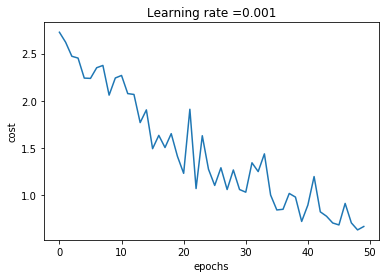

Train Accuracy: 0.875
Test Accuracy: 0.136364
Time elapsed: 39.009233236312866


In [11]:
t = time.time()

_, _, _, parameters = model(X_train, Y_train, X_val, Y_val, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 50, minibatch_size = 50, dropout = 0.5, dropout_conv = 1, lambd = 0.0025, 
                            n_hidden_fc1 = 64, index = 6, BN = False)

        
elapsed = time.time() - t


print ('Time elapsed: %s' %elapsed)